In [1]:
import torch
from torch.utils.data import Dataset

In [2]:
import pandas as pd

full_df = pd.read_csv('full.csv')
full_df.iloc[0, :-1].shape

(11,)

In [5]:
import numpy as np

complex_data_columns = list(full_df.columns)
complex_codes = full_df['complex_code'].unique()
data = []

for complex_code in complex_codes:
    x_train = full_df[full_df['complex_code'] == complex_code].iloc[:, 0:-1].to_numpy()
    x_train_complex = np.mean(x_train, axis=0).tolist() ##Important: complex vector is generated by averaging atom vectors
    x_train_complex.append(complex_code)
    
    data.append(x_train_complex)
    

full_data = pd.DataFrame(data, columns=complex_data_columns)
full_data.to_csv('from_scratch.csv')

In [6]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(full_data, test_size=0.33, random_state=42)

train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')

print(f'size of training set: {train_df.shape[0]}')
print(f'size of validation set: {val_df.shape[0]}')

size of training set: 60
size of validation set: 31


In [23]:
#check the types of columns available
print(f'columns available: {list(train_df.columns)}')
print(f'No. of columns present: {len(list(train_df.columns)[:-1])}')

columns available: ['element_type', 'residue_type', 'hydrophobic_interactions', 'hydrogen_bonds', 'water_bridges', 'pi_stacks', 'pi_cation_interactions', 'halogen_bonds', 'salt_bridges', 'metal_complexes', 'origin_type', 'complex_code']
No. of columns present: 11


## Target variable distribution for training and validation sets

In [28]:
def get_targets(complex_codes, db_path):
    db = pd.read_csv(db_path)
    targets = []
    for code in complex_codes:
        mt_code, cid, _ = code.split('_')
        y_train = db.loc[(db['mt_code'] == mt_code) & (db['cid'] == int(cid))].iloc[0, 11] 
        targets.append(y_train)
    
    return targets

In [29]:
train_complex_codes = train_df.loc[:, 'complex_code'].unique()
val_complex_codes = val_df.loc[:, 'complex_code'].unique()


train_targets = get_targets(train_complex_codes, 'test_db/single_near_mutant_CYP3A4_db.csv')
val_targets = get_targets(val_complex_codes, 'test_db/single_near_mutant_CYP3A4_db.csv')

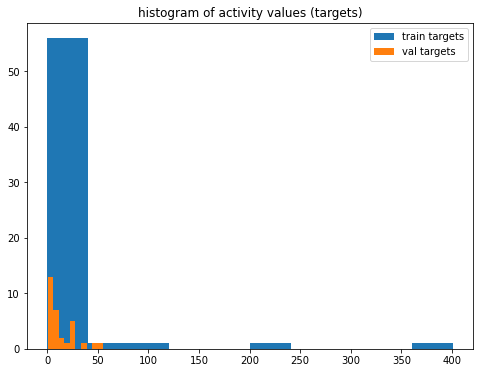

In [41]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(train_targets, label='train targets')
plt.hist(val_targets, label='val targets')
plt.title("histogram of activity values (targets)") 
plt.legend(loc='upper right')
plt.show()

## Creating custom dataset class

In [26]:
# tested
class BindingSiteDataset(Dataset):
    
    def __init__(self, path_to_data, path_to_db):
        self.df = pd.read_csv(path_to_data)
        self.db = pd.read_csv(path_to_db)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        complex_name = self.df.iloc[index, -1]
        mt_code, cid, _ = complex_name.split('_')
        #get activity value for the first reaction in our dataframe
        y_true = self.db.loc[(self.db['mt_code'] == mt_code) & (self.db['cid'] == int(cid))].iloc[0, 11] 
        return torch.from_numpy(self.df.iloc[index, :-1].to_numpy().astype('float64')).float(), torch.Tensor([y_true]).float()

## Use cuda to speed up training

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [9]:
class SimpleNNRegression(torch.nn.Module):
    
    def __init__(self):
        super(SimpleNNRegression, self).__init__()
        
        self.fnn = torch.nn.Sequential(
                torch.nn.Linear(in_features=12, out_features=20),
                torch.nn.ReLU(),
                torch.nn.Linear(in_features=20, out_features=5),
                torch.nn.ReLU(),
                torch.nn.Linear(in_features=5, out_features=1),
                torch.nn.ReLU()  
        )
    
    def forward(self, complex_vector):
        return self.fnn(complex_vector)

In [19]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    model.train()
    error = 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        # convert from torch to numpy again, X,y are of type torch.tensor, so that we could perform normalisation
        X_np = X.detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()
        
        #convert from numpy to torch again
        X_normalised, y_normalised = torch.from_numpy(scaler.fit_transform(X_np)), torch.from_numpy(scaler.fit_transform(y_np))
        
        pred = model(X_normalised)
        loss = loss_fn(pred, y_normalised)
        error += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return error

def test_loop(val_dataloader, model, loss_fn):
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    model.eval()
    error = 0
    
    with torch.no_grad():
        for X, y in val_dataloader:
            # convert from torch to numpy again, X,y are of type torch.tensor, so that we could perform normalisation
            X_np = X.detach().cpu().numpy()
            y_np = y.detach().cpu().numpy()
            
            #convert from numpy to torch again
            X_normalised, y_normalised = torch.from_numpy(scaler.fit_transform(X_np)), torch.from_numpy(scaler.fit_transform(y_np))
            pred = model(X_normalised)
            error += loss_fn(pred, y_normalised).item()
            
    return error

In [21]:
from torch.utils.data import DataLoader

train_data = BindingSiteDataset('train_df.csv', 'test_db/single_near_mutant_CYP3A4_db.csv')
val_data = BindingSiteDataset('val_df.csv', 'test_db/single_near_mutant_CYP3A4_db.csv')

train_dataloader = DataLoader(train_data, batch_size=60, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=30, shuffle=True)

model = SimpleNNRegression()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

epochs = 10000

for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(val_dataloader, model, loss_fn)
    print(f'epoch {t+1} train loss: {train_loss} val loss: {test_loss}')

epoch 1 train loss: 1.025572419166565 val loss: 0.9808834862196818
epoch 2 train loss: 0.9605900645256042 val loss: 0.9663691418536473
epoch 3 train loss: 0.9075292348861694 val loss: 0.9386023331899196
epoch 4 train loss: 0.8453579545021057 val loss: 0.9734110787976533
epoch 5 train loss: 0.7994402050971985 val loss: 1.0327176266109745
epoch 6 train loss: 0.7298619747161865 val loss: 1.0892740488052368
epoch 7 train loss: 0.6719976663589478 val loss: 1.1218332052230835
epoch 8 train loss: 0.6032238602638245 val loss: 1.2342036962509155
epoch 9 train loss: 0.5235078930854797 val loss: 1.3329273462295532
epoch 10 train loss: 0.4342758357524872 val loss: 1.45780348777771
epoch 11 train loss: 0.3674229383468628 val loss: 1.7768745422363281
epoch 12 train loss: 0.3227258622646332 val loss: 1.7299941778182983
epoch 13 train loss: 0.2656433880329132 val loss: 0.988638699054718
epoch 14 train loss: 0.22569800913333893 val loss: 2.389899492263794
epoch 15 train loss: 0.22710399329662323 val lo

epoch 121 train loss: 0.19012098014354706 val loss: 2.241429567337036
epoch 122 train loss: 0.18905414640903473 val loss: 2.604830265045166
epoch 123 train loss: 0.1904124915599823 val loss: 2.4985389709472656
epoch 124 train loss: 0.189854234457016 val loss: 2.448377847671509
epoch 125 train loss: 0.19066879153251648 val loss: 2.7480854988098145
epoch 126 train loss: 0.18991619348526 val loss: 2.4778482913970947
epoch 127 train loss: 0.1900382936000824 val loss: 2.4200308322906494
epoch 128 train loss: 0.18918952345848083 val loss: 2.4150161743164062
epoch 129 train loss: 0.18911592662334442 val loss: 2.137371778488159
epoch 130 train loss: 0.18859705328941345 val loss: 2.4931716918945312
epoch 131 train loss: 0.18867792189121246 val loss: 2.213623285293579
epoch 132 train loss: 0.1912679672241211 val loss: 2.4554688930511475
epoch 133 train loss: 0.19167263805866241 val loss: 2.249356269836426
epoch 134 train loss: 0.1914619654417038 val loss: 2.634355068206787
epoch 135 train loss: 

epoch 238 train loss: 0.18973813951015472 val loss: 2.298313617706299
epoch 239 train loss: 0.18520599603652954 val loss: 2.3143417835235596
epoch 240 train loss: 0.18873192369937897 val loss: 2.2949721813201904
epoch 241 train loss: 0.1850000023841858 val loss: 2.617244005203247
epoch 242 train loss: 0.18801532685756683 val loss: 2.5742082595825195
epoch 243 train loss: 0.18519236147403717 val loss: 2.126213550567627
epoch 244 train loss: 0.1858247071504593 val loss: 2.262024164199829
epoch 245 train loss: 0.1858438104391098 val loss: 2.1793081760406494
epoch 246 train loss: 0.18387196958065033 val loss: 2.149310350418091
epoch 247 train loss: 0.18534761667251587 val loss: 2.3985984325408936
epoch 248 train loss: 0.18345995247364044 val loss: 2.491076707839966
epoch 249 train loss: 0.18567787110805511 val loss: 2.5271809101104736
epoch 250 train loss: 0.18331627547740936 val loss: 2.0523946285247803
epoch 251 train loss: 0.1843995600938797 val loss: 2.2564985752105713
epoch 252 train 

epoch 355 train loss: 0.16898176074028015 val loss: 2.272434949874878
epoch 356 train loss: 0.16877633333206177 val loss: 2.212167501449585
epoch 357 train loss: 0.16841457784175873 val loss: 1.9760245084762573
epoch 358 train loss: 0.1669289469718933 val loss: 2.2824671268463135
epoch 359 train loss: 0.17464584112167358 val loss: 2.554138660430908
epoch 360 train loss: 0.18937046825885773 val loss: 2.681420087814331
epoch 361 train loss: 0.17864087224006653 val loss: 2.6176180839538574
epoch 362 train loss: 0.17892217636108398 val loss: 2.51115345954895
epoch 363 train loss: 0.18269090354442596 val loss: 2.2734785079956055
epoch 364 train loss: 0.16546984016895294 val loss: 2.2723419666290283
epoch 365 train loss: 0.1944960206747055 val loss: 2.2602250576019287
epoch 366 train loss: 0.1941538155078888 val loss: 2.2116522789001465
epoch 367 train loss: 0.20096063613891602 val loss: 2.1577999591827393
epoch 368 train loss: 0.2021373063325882 val loss: 2.008485794067383
epoch 369 train l

epoch 472 train loss: 0.19128291308879852 val loss: 2.968806743621826
epoch 473 train loss: 0.19127969443798065 val loss: 3.068676233291626
epoch 474 train loss: 0.19128207862377167 val loss: 2.9709246158599854
epoch 475 train loss: 0.19128023087978363 val loss: 3.1076765060424805
epoch 476 train loss: 0.19128084182739258 val loss: 2.5099093914031982
epoch 477 train loss: 0.19128090143203735 val loss: 2.8126180171966553
epoch 478 train loss: 0.19127991795539856 val loss: 3.0749223232269287
epoch 479 train loss: 0.19128113985061646 val loss: 3.0772974491119385
epoch 480 train loss: 0.19127964973449707 val loss: 3.075373411178589
epoch 481 train loss: 0.19128088653087616 val loss: 3.0735256671905518
epoch 482 train loss: 0.19127987325191498 val loss: 2.7136118412017822
epoch 483 train loss: 0.1912802904844284 val loss: 3.1291422843933105
epoch 484 train loss: 0.19128026068210602 val loss: 2.8403828144073486
epoch 485 train loss: 0.191279798746109 val loss: 3.0570363998413086
epoch 486 tr

epoch 589 train loss: 0.19127964973449707 val loss: 2.8996646404266357
epoch 590 train loss: 0.1912795901298523 val loss: 3.1072490215301514
epoch 591 train loss: 0.19127966463565826 val loss: 3.1050469875335693
epoch 592 train loss: 0.19127966463565826 val loss: 2.9246022701263428
epoch 593 train loss: 0.19127966463565826 val loss: 2.899657964706421
epoch 594 train loss: 0.19127961993217468 val loss: 2.5113368034362793
epoch 595 train loss: 0.19127963483333588 val loss: 2.8891823291778564
epoch 596 train loss: 0.19127966463565826 val loss: 3.7512333393096924
epoch 597 train loss: 0.19127964973449707 val loss: 3.0638344287872314
epoch 598 train loss: 0.19127964973449707 val loss: 3.0719070434570312
epoch 599 train loss: 0.19127963483333588 val loss: 2.924597978591919
epoch 600 train loss: 0.19127964973449707 val loss: 2.8891777992248535
epoch 601 train loss: 0.19127964973449707 val loss: 2.929029941558838
epoch 602 train loss: 0.19127964973449707 val loss: 2.7117927074432373
epoch 603 

epoch 706 train loss: 0.1912796050310135 val loss: 2.9245975017547607
epoch 707 train loss: 0.1912796050310135 val loss: 3.0766518115997314
epoch 708 train loss: 0.19127961993217468 val loss: 3.0766518115997314
epoch 709 train loss: 0.19127963483333588 val loss: 2.8406362533569336
epoch 710 train loss: 0.19127963483333588 val loss: 1.6166273355484009
epoch 711 train loss: 0.1912796050310135 val loss: 2.806244373321533
epoch 712 train loss: 0.1912795901298523 val loss: 3.1054089069366455
epoch 713 train loss: 0.19127963483333588 val loss: 2.8129897117614746
epoch 714 train loss: 0.1912796050310135 val loss: 2.840636968612671
epoch 715 train loss: 0.19127963483333588 val loss: 3.130033254623413
epoch 716 train loss: 0.19127963483333588 val loss: 1.6166282892227173
epoch 717 train loss: 0.19127963483333588 val loss: 2.9290215969085693
epoch 718 train loss: 0.19127961993217468 val loss: 2.8129892349243164
epoch 719 train loss: 0.19127966463565826 val loss: 2.92459774017334
epoch 720 train 

KeyboardInterrupt: 

In [155]:
print(train_truths)
print('\n')
print(val_truths)

[tensor([[2.2300]]), tensor([[18.7000]]), tensor([[17.5000]]), tensor([[6.7900]]), tensor([[13.]]), tensor([[14.4000]]), tensor([[16.4000]]), tensor([[229.]]), tensor([[36.]]), tensor([[29.]]), tensor([[10.4000]]), tensor([[7.1040]]), tensor([[0.5100]]), tensor([[28.]]), tensor([[0.1200]]), tensor([[4.7000]]), tensor([[4.3000]]), tensor([[17.3000]]), tensor([[3.6000]]), tensor([[3.2000]]), tensor([[4.3000]]), tensor([[9.1000]]), tensor([[1.7700]]), tensor([[28.]]), tensor([[16.6000]]), tensor([[4.5000]]), tensor([[401.]]), tensor([[14.9000]]), tensor([[5.5000]]), tensor([[3.9600]]), tensor([[8.2620]]), tensor([[4.1000]]), tensor([[1.9000]]), tensor([[47.6000]]), tensor([[0.8200]]), tensor([[11.]]), tensor([[3.0900]]), tensor([[23.8000]]), tensor([[20.9800]]), tensor([[11.2000]]), tensor([[6.8000]]), tensor([[1.6500]]), tensor([[9.5700]]), tensor([[30.2000]]), tensor([[30.3000]]), tensor([[6.7000]]), tensor([[86.]]), tensor([[6.4000]]), tensor([[1.1300]]), tensor([[13.5000]]), tensor([[

/home/howc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

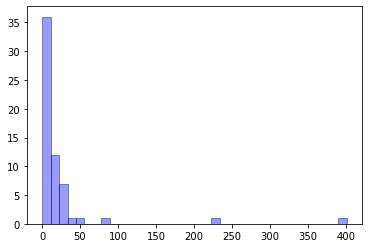

In [160]:
import seaborn as sns

sns.distplot(train_truths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:>

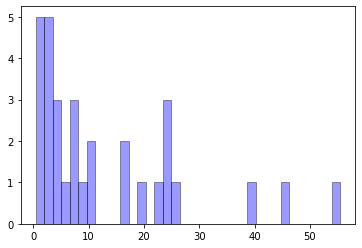

In [161]:
sns.distplot(val_truths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})